In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, QuantileTransformer
from sklearn.impute import SimpleImputer
import numpy as np

In [2]:
import sys
import os
from os.path import dirname
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
sys.path.append(dirname('../src'))
from src.utils import utils
data = utils.load_df("../Data/feature_eng.pkl")
data.head(5)

,cx_curp,ventana,sexo,sum_num_consultas,avg_num_consultas_by_year,dm,año_dx_dm,dm_años_int,renal,renal_años_int,...,SOLUCIONES ELECTROLITICAS,SUEROS INMUNITARIOS,TOXOIDES,TROMBOLITICOS,VACUNAS,VITAMINAS,GAS MEDICINAL,FORMULA POLIMERICA,label,fn_diastolica_a
0,AAAZ581217189U5PC3,1,1,26,13,1,1998,0.375,0,0,...,0,0,0,0,0,1,0,0,1,74.0
1,AAAZ581217189U5PC3,2,1,21,10.5,1,1998,1.19048,0,0,...,0,0,0,0,0,0,0,0,1,70.0
2,AAAZ581217189U5PC3,3,1,22,11,1,1998,2.40909,0,0,...,0,0,0,0,0,1,0,0,1,100.0
3,AAAZ581217189U5PC3,4,1,24,12,1,1998,3.29167,0,0,...,0,0,0,0,0,1,0,0,1,80.0
4,AADV5603014KS44QC1,1,1,25,12.5,1,1999,NaN,0,0,...,0,0,0,0,0,0,0,0,0,80.0


<AxesSubplot:>

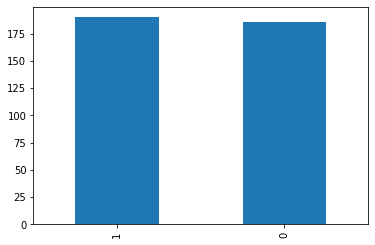

In [3]:
data['label'].value_counts().plot.bar()

In [4]:
data[data['sum_num_consultas']==0]

,cx_curp,ventana,sexo,sum_num_consultas,avg_num_consultas_by_year,dm,año_dx_dm,dm_años_int,renal,renal_años_int,...,SOLUCIONES ELECTROLITICAS,SUEROS INMUNITARIOS,TOXOIDES,TROMBOLITICOS,VACUNAS,VITAMINAS,GAS MEDICINAL,FORMULA POLIMERICA,label,fn_diastolica_a
13,AEDJ750301XGAEGRC1,3,,0,0,0,NaN,NaN,0,NaN,...,0,0,0,0,0,0,0,0,0,NaN
32,BOLM631201LV35XPC1,10,,0,0,1,NaN,NaN,0,NaN,...,0,0,0,0,0,0,0,0,1,NaN
67,COPI690401V91QCRC2,5,,0,0,0,NaN,NaN,0,NaN,...,0,0,0,0,0,0,0,0,0,NaN
68,COPI690401V91QCRC2,6,,0,0,0,NaN,NaN,0,NaN,...,0,0,0,0,0,0,0,0,0,NaN
69,COPI690401V91QCRC2,7,,0,0,0,NaN,NaN,0,NaN,...,0,0,0,0,0,0,0,0,0,NaN
117,EAGG5405015QC44QC1,11,,0,0,1,NaN,NaN,0,NaN,...,0,0,0,0,0,0,0,0,1,NaN
124,GAMP640301UJL5SEE1,7,,0,0,0,NaN,NaN,0,NaN,...,0,0,0,0,0,0,0,0,0,NaN
125,GAMP640301UJL5SEE1,8,,0,0,0,NaN,NaN,0,NaN,...,0,0,0,0,0,0,0,0,0,NaN
152,GUSJ5712286XUN73A2,2,,0,0,0,NaN,NaN,0,NaN,...,0,0,0,0,0,0,0,0,0,NaN
153,GUSJ5712286XUN73A2,3,,0,0,0,NaN,NaN,0,NaN,...,0,0,0,0,0,0,0,0,0,NaN


- Eliminando filas que no aportan información

In [5]:
data = data[data['sum_num_consultas']>0]
data = data.reset_index()
data = data.drop(columns=['index'])
data

,cx_curp,ventana,sexo,sum_num_consultas,avg_num_consultas_by_year,dm,año_dx_dm,dm_años_int,renal,renal_años_int,...,SOLUCIONES ELECTROLITICAS,SUEROS INMUNITARIOS,TOXOIDES,TROMBOLITICOS,VACUNAS,VITAMINAS,GAS MEDICINAL,FORMULA POLIMERICA,label,fn_diastolica_a
0,AAAZ581217189U5PC3,1,1,26,13,1,1998,0.375,0,0,...,0,0,0,0,0,1,0,0,1,74.0
1,AAAZ581217189U5PC3,2,1,21,10.5,1,1998,1.19048,0,0,...,0,0,0,0,0,0,0,0,1,70.0
2,AAAZ581217189U5PC3,3,1,22,11,1,1998,2.40909,0,0,...,0,0,0,0,0,1,0,0,1,100.0
3,AAAZ581217189U5PC3,4,1,24,12,1,1998,3.29167,0,0,...,0,0,0,0,0,1,0,0,1,80.0
4,AADV5603014KS44QC1,1,1,25,12.5,1,1999,NaN,0,0,...,0,0,0,0,0,0,0,0,0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,ZEPL5503219FZQ6QC2,3,2,6,3,0,NaN,NaN,0,0,...,0,0,0,0,0,1,0,0,0,80.0
342,ZEPL5503219FZQ6QC2,4,2,9,4.5,0,NaN,NaN,0,0,...,0,0,0,0,0,1,0,0,1,80.0
343,ZEPL5503219FZQ6QC2,5,2,16,8,1,2009,0,0,0,...,0,0,0,0,0,1,0,0,1,80.0
344,ZEPL5503219FZQ6QC2,6,2,21,10.5,1,2009,0.411765,0,0,...,0,0,0,0,0,1,0,0,1,60.0


<AxesSubplot:>

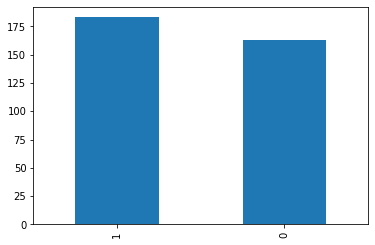

In [6]:
data['label'].value_counts().plot.bar()

- Eliminando columnas que no aportan información

In [7]:
subset_df = data.loc[:, data.isnull().all()]
col_null = list(subset_df.columns)
col_null

['fn_distolica_a']

In [8]:
data.drop(col_null, axis=1, inplace=True)
list(data.columns)

['cx_curp',
 'ventana',
 'sexo',
 'sum_num_consultas',
 'avg_num_consultas_by_year',
 'dm',
 'año_dx_dm',
 'dm_años_int',
 'renal',
 'renal_años_int',
 'edad_range',
 'epoca_nac',
 'imc_range',
 'num_med',
 'avg_num_med',
 'min_num_med',
 'max_num_med',
 'preglucosa',
 'num_med_preglucosa',
 'avg_preglucosa',
 'min_preglucosa',
 'max_preglucosa',
 'postglucosa',
 'num_med_postglucosa',
 'avg_postglucosa',
 'min_postglucosa',
 'max_postglucosa',
 'colesterol',
 'num_med_colesterol',
 'avg_colesterol',
 'min_colesterol',
 'max_colesterol',
 'trigliceridos',
 'num_med_trigliceridos',
 'avg_trigliceridos',
 'min_trigliceridos',
 'max_trigliceridos',
 'hdl',
 'num_med_hdl',
 'avg_hdl',
 'min_hdl',
 'max_hdl',
 'ldl',
 'num_med_ldl',
 'avg_ldl',
 'min_ldl',
 'max_ldl',
 'presion_arterial',
 'num_med_presion_a',
 'avg_sistolica_a',
 'min_sistolica_a',
 'max_sistolica_a',
 'fn_sistolica_a',
 'avg_diastolica_a',
 'min_diastolica_a',
 'max_diastolica_a',
 'map_g',
 'hba1c',
 'num_med_hba1c',
 'a

In [9]:
display(data[['imc_range']])
data = data.loc[:,~data.columns.duplicated()].copy()
data[['imc_range']]

,imc_range
0,2
1,3
2,3
3,3
4,4
...,...
341,3
342,3
343,2
344,2


,imc_range
0,2
1,3
2,3
3,3
4,4
...,...
341,3
342,3
343,2
344,2


In [10]:
data.shape

(346, 288)

In [11]:
data[pd.isna(data['imc_range'])]

,cx_curp,ventana,sexo,sum_num_consultas,avg_num_consultas_by_year,dm,año_dx_dm,dm_años_int,renal,renal_años_int,...,SOLUCIONES ELECTROLITICAS,SUEROS INMUNITARIOS,TOXOIDES,TROMBOLITICOS,VACUNAS,VITAMINAS,GAS MEDICINAL,FORMULA POLIMERICA,label,fn_diastolica_a
244,PAGJ690411WZ0YDRC1,3,1,1,0.5,1,2007,3,0,0,...,0,0,0,0,0,0,0,0,0,NaN
245,PAGJ690411WZ0YDRC1,4,1,1,0.5,1,2007,3,0,0,...,0,0,0,0,0,0,0,0,0,NaN
249,PAGJ690411WZ0YDRC1,15,1,1,0.5,1,2007,14,0,0,...,0,0,0,0,0,0,0,0,0,NaN


In [12]:
data[data['cx_curp']=='PAGJ690411WZ0YDRC1'][['ventana','imc_range']]

,ventana,imc_range
243,1,4
244,3,NaN
245,4,NaN
246,12,3
247,13,3
248,14,3
249,15,NaN


In [13]:
data[pd.isna(data['label'])][['cx_curp','ventana','label']]

,cx_curp,ventana,label


In [14]:
cx_curp = data['cx_curp'] 
data = data.drop(['cx_curp'], axis=1)

In [15]:
data

,ventana,sexo,sum_num_consultas,avg_num_consultas_by_year,dm,año_dx_dm,dm_años_int,renal,renal_años_int,edad_range,...,SOLUCIONES ELECTROLITICAS,SUEROS INMUNITARIOS,TOXOIDES,TROMBOLITICOS,VACUNAS,VITAMINAS,GAS MEDICINAL,FORMULA POLIMERICA,label,fn_diastolica_a
0,1,1,26,13,1,1998,0.375,0,0,6,...,0,0,0,0,0,1,0,0,1,74.0
1,2,1,21,10.5,1,1998,1.19048,0,0,6,...,0,0,0,0,0,0,0,0,1,70.0
2,3,1,22,11,1,1998,2.40909,0,0,6,...,0,0,0,0,0,1,0,0,1,100.0
3,4,1,24,12,1,1998,3.29167,0,0,7,...,0,0,0,0,0,1,0,0,1,80.0
4,1,1,25,12.5,1,1999,NaN,0,0,5,...,0,0,0,0,0,0,0,0,0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,3,2,6,3,0,NaN,NaN,0,0,6,...,0,0,0,0,0,1,0,0,0,80.0
342,4,2,9,4.5,0,NaN,NaN,0,0,6,...,0,0,0,0,0,1,0,0,1,80.0
343,5,2,16,8,1,2009,0,0,0,6,...,0,0,0,0,0,1,0,0,1,80.0
344,6,2,21,10.5,1,2009,0.411765,0,0,6,...,0,0,0,0,0,1,0,0,1,60.0


In [16]:
data[pd.isna(data['label'])][['ventana','label']]

,ventana,label


In [17]:
data.shape

(346, 287)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Columns: 287 entries, ventana to fn_diastolica_a
dtypes: float64(1), object(286)
memory usage: 775.9+ KB


In [19]:
c = list(data.columns)
c

['ventana',
 'sexo',
 'sum_num_consultas',
 'avg_num_consultas_by_year',
 'dm',
 'año_dx_dm',
 'dm_años_int',
 'renal',
 'renal_años_int',
 'edad_range',
 'epoca_nac',
 'imc_range',
 'num_med',
 'avg_num_med',
 'min_num_med',
 'max_num_med',
 'preglucosa',
 'num_med_preglucosa',
 'avg_preglucosa',
 'min_preglucosa',
 'max_preglucosa',
 'postglucosa',
 'num_med_postglucosa',
 'avg_postglucosa',
 'min_postglucosa',
 'max_postglucosa',
 'colesterol',
 'num_med_colesterol',
 'avg_colesterol',
 'min_colesterol',
 'max_colesterol',
 'trigliceridos',
 'num_med_trigliceridos',
 'avg_trigliceridos',
 'min_trigliceridos',
 'max_trigliceridos',
 'hdl',
 'num_med_hdl',
 'avg_hdl',
 'min_hdl',
 'max_hdl',
 'ldl',
 'num_med_ldl',
 'avg_ldl',
 'min_ldl',
 'max_ldl',
 'presion_arterial',
 'num_med_presion_a',
 'avg_sistolica_a',
 'min_sistolica_a',
 'max_sistolica_a',
 'fn_sistolica_a',
 'avg_diastolica_a',
 'min_diastolica_a',
 'max_diastolica_a',
 'map_g',
 'hba1c',
 'num_med_hba1c',
 'avg_hba1c',
 

In [20]:
#from src.utils import utils, processing
#string_variables = data.select_dtypes(include = 'object').columns.values
#(len(string_variables), string_variables)

In [21]:
for var in c:
    print(var)
    data[var] = pd.to_numeric(data[var])

ventana
sexo
sum_num_consultas
avg_num_consultas_by_year
dm
año_dx_dm
dm_años_int
renal
renal_años_int
edad_range
epoca_nac
imc_range
num_med
avg_num_med
min_num_med
max_num_med
preglucosa
num_med_preglucosa
avg_preglucosa
min_preglucosa
max_preglucosa
postglucosa
num_med_postglucosa
avg_postglucosa
min_postglucosa
max_postglucosa
colesterol
num_med_colesterol
avg_colesterol
min_colesterol
max_colesterol
trigliceridos
num_med_trigliceridos
avg_trigliceridos
min_trigliceridos
max_trigliceridos
hdl
num_med_hdl
avg_hdl
min_hdl
max_hdl
ldl
num_med_ldl
avg_ldl
min_ldl
max_ldl
presion_arterial
num_med_presion_a
avg_sistolica_a
min_sistolica_a
max_sistolica_a
fn_sistolica_a
avg_diastolica_a
min_diastolica_a
max_diastolica_a
map_g
hba1c
num_med_hba1c
avg_hba1c
min_hba1c
max_hba1c
plaquetas
num_med_plaquetas
avg_plaquetas
min_plaquetas
max_plaquetas
creatinina
num_med_creatinina
avg_creatinina
min_creatinina
max_creatinina
acido_urico
num_med_acido_urico
avg_acido_urico
min_acido_urico
max_acid

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Columns: 287 entries, ventana to fn_diastolica_a
dtypes: float64(65), int64(222)
memory usage: 775.9 KB


In [23]:
from src.utils import utils, processing
string_variables = data.select_dtypes(include = 'object').columns.values
(len(string_variables), string_variables)

(0, array([], dtype=object))

In [24]:
data.to_csv("dat.csv")

In [25]:
col = list(data.columns)
col

['ventana',
 'sexo',
 'sum_num_consultas',
 'avg_num_consultas_by_year',
 'dm',
 'año_dx_dm',
 'dm_años_int',
 'renal',
 'renal_años_int',
 'edad_range',
 'epoca_nac',
 'imc_range',
 'num_med',
 'avg_num_med',
 'min_num_med',
 'max_num_med',
 'preglucosa',
 'num_med_preglucosa',
 'avg_preglucosa',
 'min_preglucosa',
 'max_preglucosa',
 'postglucosa',
 'num_med_postglucosa',
 'avg_postglucosa',
 'min_postglucosa',
 'max_postglucosa',
 'colesterol',
 'num_med_colesterol',
 'avg_colesterol',
 'min_colesterol',
 'max_colesterol',
 'trigliceridos',
 'num_med_trigliceridos',
 'avg_trigliceridos',
 'min_trigliceridos',
 'max_trigliceridos',
 'hdl',
 'num_med_hdl',
 'avg_hdl',
 'min_hdl',
 'max_hdl',
 'ldl',
 'num_med_ldl',
 'avg_ldl',
 'min_ldl',
 'max_ldl',
 'presion_arterial',
 'num_med_presion_a',
 'avg_sistolica_a',
 'min_sistolica_a',
 'max_sistolica_a',
 'fn_sistolica_a',
 'avg_diastolica_a',
 'min_diastolica_a',
 'max_diastolica_a',
 'map_g',
 'hba1c',
 'num_med_hba1c',
 'avg_hba1c',
 

In [26]:
len(col)

287

### Imputaciones

In [27]:
# Imputation
my_imputer = SimpleImputer()
d_inp = pd.DataFrame(my_imputer.fit_transform(data))
d_inp

,0,1,2,3,4,5,6,7,8,9,...,277,278,279,280,281,282,283,284,285,286
0,1.0,1.0,26.0,13.0,1.0,1998.000000,0.375000,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,74.0
1,2.0,1.0,21.0,10.5,1.0,1998.000000,1.190476,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,70.0
2,3.0,1.0,22.0,11.0,1.0,1998.000000,2.409091,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,100.0
3,4.0,1.0,24.0,12.0,1.0,1998.000000,3.291667,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,80.0
4,1.0,1.0,25.0,12.5,1.0,1999.000000,1.709221,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,3.0,2.0,6.0,3.0,0.0,2005.713147,1.709221,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,80.0
342,4.0,2.0,9.0,4.5,0.0,2005.713147,1.709221,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,80.0
343,5.0,2.0,16.0,8.0,1.0,2009.000000,0.000000,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,80.0
344,6.0,2.0,21.0,10.5,1.0,2009.000000,0.411765,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,60.0


In [28]:
d_inp.shape

(346, 287)

In [29]:
d_inp.columns = col
d_inp

,ventana,sexo,sum_num_consultas,avg_num_consultas_by_year,dm,año_dx_dm,dm_años_int,renal,renal_años_int,edad_range,...,SOLUCIONES ELECTROLITICAS,SUEROS INMUNITARIOS,TOXOIDES,TROMBOLITICOS,VACUNAS,VITAMINAS,GAS MEDICINAL,FORMULA POLIMERICA,label,fn_diastolica_a
0,1.0,1.0,26.0,13.0,1.0,1998.000000,0.375000,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,74.0
1,2.0,1.0,21.0,10.5,1.0,1998.000000,1.190476,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,70.0
2,3.0,1.0,22.0,11.0,1.0,1998.000000,2.409091,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,100.0
3,4.0,1.0,24.0,12.0,1.0,1998.000000,3.291667,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,80.0
4,1.0,1.0,25.0,12.5,1.0,1999.000000,1.709221,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,3.0,2.0,6.0,3.0,0.0,2005.713147,1.709221,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,80.0
342,4.0,2.0,9.0,4.5,0.0,2005.713147,1.709221,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,80.0
343,5.0,2.0,16.0,8.0,1.0,2009.000000,0.000000,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,80.0
344,6.0,2.0,21.0,10.5,1.0,2009.000000,0.411765,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,60.0


In [30]:
#df_st

In [31]:
#df = pd.merge(d_inp, df_st, left_index=True, right_index=True)  
df = d_inp.copy()
df

,ventana,sexo,sum_num_consultas,avg_num_consultas_by_year,dm,año_dx_dm,dm_años_int,renal,renal_años_int,edad_range,...,SOLUCIONES ELECTROLITICAS,SUEROS INMUNITARIOS,TOXOIDES,TROMBOLITICOS,VACUNAS,VITAMINAS,GAS MEDICINAL,FORMULA POLIMERICA,label,fn_diastolica_a
0,1.0,1.0,26.0,13.0,1.0,1998.000000,0.375000,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,74.0
1,2.0,1.0,21.0,10.5,1.0,1998.000000,1.190476,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,70.0
2,3.0,1.0,22.0,11.0,1.0,1998.000000,2.409091,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,100.0
3,4.0,1.0,24.0,12.0,1.0,1998.000000,3.291667,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,80.0
4,1.0,1.0,25.0,12.5,1.0,1999.000000,1.709221,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,3.0,2.0,6.0,3.0,0.0,2005.713147,1.709221,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,80.0
342,4.0,2.0,9.0,4.5,0.0,2005.713147,1.709221,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,80.0
343,5.0,2.0,16.0,8.0,1.0,2009.000000,0.000000,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,80.0
344,6.0,2.0,21.0,10.5,1.0,2009.000000,0.411765,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,60.0


In [32]:
X = df.loc[:, df.columns != 'label']
Y = df[["label"]]

In [33]:
print(X.shape)
print(Y.shape)

(346, 286)
(346, 1)


In [34]:
print(Y.size)
Y = Y.astype(int)

346


In [35]:
X.to_csv("../Data/X.csv")

In [36]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=4)

In [37]:
# Parámetros para la mejor selección de variables
grid_param = {
    'n_estimators': [100, 150],
    'min_samples_split': [2, 5, 7, 10,15]
}

#classifier = RandomForestClassifier()
classifier = RandomForestClassifier(oob_score=True, random_state=1234)

#Prepareción del GridSearch
gd_sr = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring='precision',
                     cv=2)

In [38]:
print(X_train)

     ventana  sexo  sum_num_consultas  avg_num_consultas_by_year   dm  \
20       3.0   1.0               26.0                       13.0  1.0   
139      1.0   2.0               23.0                       11.5  0.0   
206      9.0   2.0               26.0                       13.0  1.0   
262      5.0   2.0               22.0                       11.0  1.0   
16       7.0   1.0                1.0                        0.5  1.0   
..       ...   ...                ...                        ...  ...   
306      2.0   2.0               14.0                        7.0  0.0   
87       5.0   2.0               17.0                        8.5  1.0   
197     12.0   1.0                8.0                        4.0  1.0   
174      1.0   2.0                7.0                        3.5  0.0   
122     13.0   1.0               14.0                        7.0  1.0   

       año_dx_dm  dm_años_int  renal  renal_años_int  edad_range  ...  \
20   2010.000000     2.423077    0.0             0

In [39]:
print(y_train)

     label
20       1
139      1
206      1
262      1
16       1
..     ...
306      0
87       0
197      1
174      0
122      1

[242 rows x 1 columns]


In [40]:
Y

,label
0,1
1,1
2,1
3,1
4,0
...,...
341,0
342,1
343,1
344,1


In [41]:
#Fit del grid search con r
gd_sr.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=RandomForestClassifier(oob_score=True,
                                              random_state=1234),
             param_grid={'min_samples_split': [2, 5, 7, 10, 15],
                         'n_estimators': [100, 150]},
             scoring='precision')

In [42]:
# mejor configuración 
gd_sr.best_estimator_

RandomForestClassifier(n_estimators=150, oob_score=True, random_state=1234)

In [43]:
gd_sr.best_estimator_.n_features_

286

In [44]:
gd_sr.best_estimator_.oob_score_

0.8388429752066116

### Importancia de variables

In [45]:
best_rf = gd_sr.best_estimator_
best_rf.feature_importances_

array([2.65045115e-02, 3.95649865e-03, 2.53539847e-02, 2.82584062e-02,
       2.60518986e-02, 3.16066156e-02, 5.28532413e-02, 3.68817614e-04,
       0.00000000e+00, 1.81106554e-02, 1.05581434e-02, 8.13480112e-03,
       3.07394029e-02, 1.75626061e-02, 5.08970898e-04, 1.32262879e-02,
       3.86228585e-03, 2.91895907e-02, 2.19155740e-02, 3.87118017e-02,
       1.57613495e-02, 6.95283691e-03, 2.20900137e-03, 2.78327931e-03,
       2.32340324e-03, 4.49030434e-03, 1.59397655e-02, 6.27268543e-03,
       1.47621383e-02, 1.11991413e-02, 1.16972726e-02, 1.93203221e-02,
       8.98946670e-03, 1.19132889e-02, 5.39739762e-03, 7.83526369e-03,
       5.51114755e-06, 1.14110435e-04, 5.49040322e-04, 6.85339601e-04,
       1.95287443e-04, 1.57840083e-04, 6.69634479e-04, 3.26126873e-04,
       2.04525164e-04, 6.36036553e-04, 9.09601338e-05, 2.84425789e-02,
       1.40953278e-02, 1.18734963e-02, 1.12583836e-02, 1.05783193e-02,
       1.76562051e-02, 8.91391956e-03, 9.11932798e-03, 1.64458606e-03,
      

In [46]:
feature_importance = pd.DataFrame({'importance': best_rf.feature_importances_,
                                  'feature': X.columns.values})

In [47]:
importancias = feature_importance.sort_values(by="importance", ascending=False)

In [48]:
pd.set_option('display.max_rows', importancias.shape[0]+1)
importancias

,importance,feature
6,0.052853,dm_años_int
105,0.050471,enf_endocrinas
19,0.038712,min_preglucosa
5,0.031607,año_dx_dm
12,0.030739,num_med
17,0.029190,num_med_preglucosa
47,0.028443,num_med_presion_a
3,0.028258,avg_num_consultas_by_year
0,0.026505,ventana
4,0.026052,dm


In [49]:
col_imp = list(importancias[importancias['importance']>0]['feature'])
col_imp.append('label')
col_imp

['dm_años_int',
 'enf_endocrinas',
 'min_preglucosa',
 'año_dx_dm',
 'num_med',
 'num_med_preglucosa',
 'num_med_presion_a',
 'avg_num_consultas_by_year',
 'ventana',
 'dm',
 'sum_num_consultas',
 'avg_preglucosa',
 'trigliceridos',
 'edad_range',
 'avg_diastolica_a',
 'avg_num_med',
 'colesterol',
 'max_preglucosa',
 'avg_colesterol',
 'avg_sistolica_a',
 'E70_E90',
 'max_num_med',
 'avg_trigliceridos',
 'min_sistolica_a',
 'max_colesterol',
 'max_sistolica_a',
 'min_colesterol',
 'fn_sistolica_a',
 'ANALGESICOS',
 'epoca_nac',
 'ANTIANEMICOS',
 'ANTIDIABETICOS',
 'max_diastolica_a',
 'num_med_trigliceridos',
 'min_diastolica_a',
 'fn_diastolica_a',
 'imc_range',
 'max_trigliceridos',
 'postglucosa',
 'HIPOLIPEMIANTES',
 'num_med_colesterol',
 'ANTIGOTOSOS',
 'min_trigliceridos',
 'ANTITUSIGENOS',
 'EXPECTORANTES',
 'g23',
 'ANTIMICROBIANOS',
 'enf_aparato_urinario',
 'ANSIOLITICOS',
 'max_postglucosa',
 'E65_E68',
 'g6',
 'sexo',
 'enf_sist_osteomuscular_y_tejido',
 'g5',
 'DIURETICO

In [50]:
d_fe_f = pd.concat([X, Y], axis=1, join='inner')
d_fe_f

,ventana,sexo,sum_num_consultas,avg_num_consultas_by_year,dm,año_dx_dm,dm_años_int,renal,renal_años_int,edad_range,...,SOLUCIONES ELECTROLITICAS,SUEROS INMUNITARIOS,TOXOIDES,TROMBOLITICOS,VACUNAS,VITAMINAS,GAS MEDICINAL,FORMULA POLIMERICA,fn_diastolica_a,label
0,1.0,1.0,26.0,13.0,1.0,1998.000000,0.375000,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,74.0,1
1,2.0,1.0,21.0,10.5,1.0,1998.000000,1.190476,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,1
2,3.0,1.0,22.0,11.0,1.0,1998.000000,2.409091,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,100.0,1
3,4.0,1.0,24.0,12.0,1.0,1998.000000,3.291667,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,80.0,1
4,1.0,1.0,25.0,12.5,1.0,1999.000000,1.709221,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,3.0,2.0,6.0,3.0,0.0,2005.713147,1.709221,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,80.0,0
342,4.0,2.0,9.0,4.5,0.0,2005.713147,1.709221,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,80.0,1
343,5.0,2.0,16.0,8.0,1.0,2009.000000,0.000000,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,80.0,1
344,6.0,2.0,21.0,10.5,1.0,2009.000000,0.411765,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,60.0,1


In [51]:
d_fe_f = d_fe_f[col_imp]
d_fe_f

,dm_años_int,enf_endocrinas,min_preglucosa,año_dx_dm,num_med,num_med_preglucosa,num_med_presion_a,avg_num_consultas_by_year,ventana,dm,...,comp_aten_med_qx_no_clasif,enf_viricas,ANTITIROIDEOS,presion_arterial,g13,enf_cavidad_bucal_glandulas_salivales,tumores_malig_huesos_articulares_conjuntivo_piel_mama,tumores_malig_org_genitourinarios,hdl,label
0,0.375000,1.0,47.0,1998.000000,26.0,14.0,26.0,13.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
1,1.190476,1.0,67.0,1998.000000,21.0,8.0,21.0,10.5,2.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
2,2.409091,1.0,62.0,1998.000000,22.0,10.0,21.0,11.0,3.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1
3,3.291667,1.0,46.0,1998.000000,24.0,14.0,23.0,12.0,4.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1
4,1.709221,0.0,108.0,1999.000000,25.0,9.0,21.0,12.5,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,1.709221,0.0,118.0,2005.713147,6.0,1.0,6.0,3.0,3.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0
342,1.709221,0.0,99.0,2005.713147,9.0,2.0,8.0,4.5,4.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1
343,0.000000,1.0,99.0,2009.000000,16.0,3.0,12.0,8.0,5.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1
344,0.411765,1.0,90.0,2009.000000,21.0,9.0,18.0,10.5,6.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1


In [52]:
# Guardando modelo
import pickle
pickle.dump(gd_sr, open("modelo_ing.pkl", "wb"))

In [53]:
# Guardando Feature Selection
utils.save_df(d_fe_f, "../Data/feature_sel.pkl")

In [54]:
subset_df = d_fe_f.loc[:, d_fe_f.isnull().any()]
print(subset_df)

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[346 rows x 0 columns]


In [55]:
model0 = gd_sr.best_estimator_
model0
predicted_labels0 = model0.predict(X_test)
predicted_scores0 = model0.predict_proba(X_test)

In [56]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score, recall_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

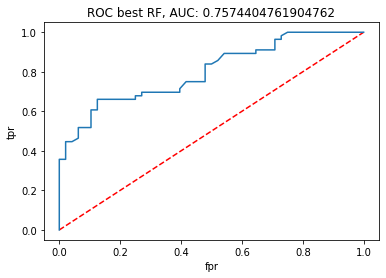

[[41  7]
 [19 37]]


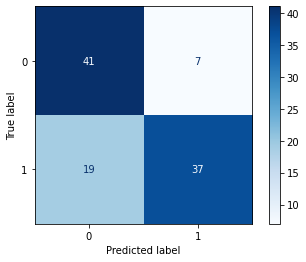

In [57]:
### Curva ROC
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, predicted_scores0[:, 1], pos_label=1)
plt.clf()
plt.plot([0, 1], [0, 1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels0)))
plt.xlabel("fpr")
plt.ylabel("tpr")
#plt.savefig('../output/ROC_curve.png', bbox_inches='tight')
plt.show()

print(confusion_matrix(y_test, predicted_labels0))
plot_confusion_matrix(model0, X_test, y_test, cmap=plt.cm.Blues)  

### Importancia de variables usando shap

In [58]:
import xgboost
import shap

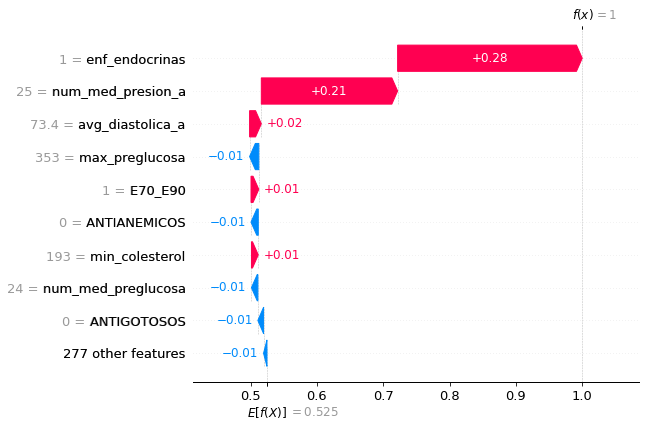

In [59]:
# train an XGBoost model
#X, y = shap.datasets.boston()
model = xgboost.XGBRegressor().fit(X_train, y_train)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

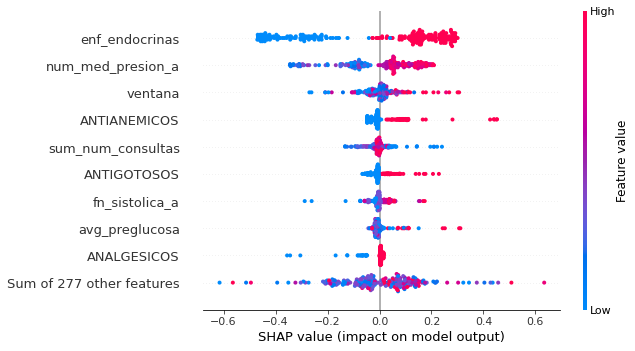

In [60]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

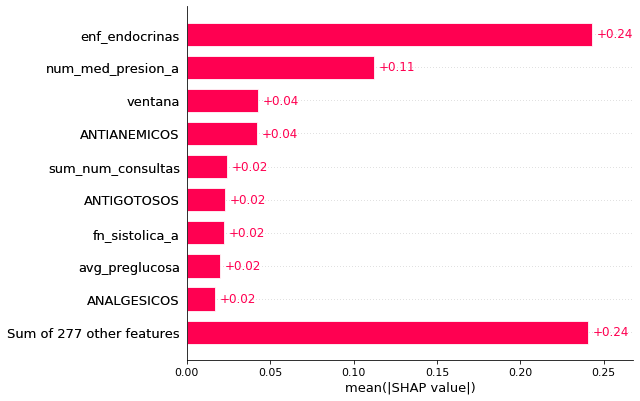

In [61]:
shap.plots.bar(shap_values)